# Assignment 1 - Image Deblurring

Name: Michael Senn<br>
Matriculation number: 16-126-880

In [1]:
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import scipy.signal
import scipy.sparse as sparse

from hessian_matrix import hessian_matrix

## Test Image

You can use the following function to create a synthetic image:



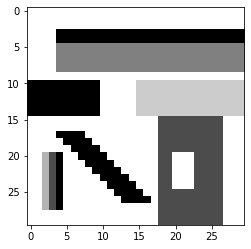

In [2]:
def create_random_binary_img_1():
    # This is going to create an array containing exclusively 1, 
    # so the image is going to be anything but random.
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(float)
    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [3]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 0 # 16-126-880 mod 4
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.  -2.   0.  -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.   0.   0.  -2.   0.   0.   0. ]
 [-2.   0.   0.   6.5 -1.5  0.  -2.   0.   0. ]
 [ 0.  -2.   0.  -1.5  9.  -1.5  0.  -2.   0. ]
 [ 0.   0.  -2.   0.  -1.5  6.5  0.   0.  -2. ]
 [ 0.   0.   0.  -2.   0.   0.   4.5 -1.5  0. ]
 [ 0.   0.   0.   0.  -2.   0.  -1.5  7.  -1.5]
 [ 0.   0.   0.   0.   0.  -2.   0.  -1.5  4.5]]


## Implementation

### Gradients

In [4]:
def no_regularization(u):
    return np.zeros(u.shape)
    
def anisotropic_regularization(u):
    """Gradient of anisotropic regularization term"""
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0, 0] = np.sign(u[0, 0] - u[1, 0]) + np.sign(u[0, 0] - u[0, 1])
    
    # Case B
    gradient[1:n-1, 0] = np.sign(u[1:n-1, 0] - u[0:n-2, 0]) + np.sign(u[1:n-1, 0] - u[2:n, 0]) + np.sign(u[1:n-1, 0] - u[1:n-1, 1])
    
    # Case C
    gradient[n-1, 0] = np.sign(u[n-1, 0] - u[n-2, 0]) + np.sign(u[n-1, 0] - u[n-1, 1])
    
    # Case D
    gradient[n-1, 1:m-1] = np.sign(u[n-1, 1:m-1] - u[n-2, 1:m-1]) + np.sign(u[n-1, 1:m-1] - u[n-1, 0:m-2]) + np.sign(u[n-1, 1:m-1] - u[n-1, 2:m])
    
    # Case E
    gradient[n-1, m-1] = np.sign(u[n-1, m-1] - u[n-2, m-1]) + np.sign(u[n-1, m-1] - u[n-1, m-2])
    
    # Case F
    gradient[1:n-1, m-1] = np.sign(u[1:n-1, m-1] - u[1:n-1, m-2]) + np.sign(u[1:n-1, m-1] - u[2:n, m-1]) + np.sign(u[1:n-1, m-1] - u[0:n-2, m-1])
    
    # Case G
    gradient[0, m-1] = np.sign(u[0, m-1] - u[0, m-2]) + np.sign(u[0, m-1] - u[1, m-1])
    
    # Case H
    gradient[0, 1:m-1] = np.sign(u[0, 1:m-1] - u[1, 1:m-1]) + np.sign(u[0, 1:m-1] - u[0, 2:m]) + np.sign(u[0, 1:m-1] - u[0, 0:m-2])
    
    # Case I
    gradient[1:n-1, 1:m-1] = np.sign(u[1:n-1, 1:m-1] - u[2:n, 1:m-1]) + np.sign(u[1:n-1, 1:m-1] - u[1:n-1, 2:m]) + np.sign(u[1:n-1, 1:m-1] - u[0:n-2, 1:m-1]) + np.sign(u[1:n-1, 1:m-1] - u[1:n-1, 0:m-2])
    
    return gradient

def gaussian_regularization(u):
    """Gradient of Gaussian regularization term"""
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0, 0] = 4 * u[0, 0] - 2 * u[1, 0] - 2 * u[0, 1]
    
    # Case B
    gradient[1:n-1, 0] = 6 * u[1:n-1, 0] - 2 * u[0:n-2, 0] - 2 * u[2:n, 0] - 2 * u[1:n-1, 1]
    
    # Case C
    gradient[n-1, 0] = 4 * u[n-1, 0] - 2 * u[n-2, 0] - 2 * u[n-1, 1]
    
    # Case D
    gradient[n-1, 1:m-1] = 6 * u[n-1, 1:m-1] - 2 * u[n-2, 1:m-1] - 2 * u[n-1, 0:m-2] - 2 * u[n-1, 2:m]
    
    # Case E
    gradient[n-1, m-1] = 4 * u[n-1, m-1] - 2 * u[n-2, m-1] - 2 * u[n-1, m-2]
    
    # Case F
    gradient[1:n-1, m-1] = 6 * u[1:n-1, m-1] - 2 * u[1:n-1, m-2] - 2 * u[2:n, m-1] - 2 * u[0:n-2, m-1]
    
    # Case G
    gradient[0, m-1] = 4 * u[0, m-1] - 2 * u[0, m-2] - 2 * u[1, m-1]
    
    # Case H
    gradient[0, 1:m-1] = 6 * u[0, 1:m-1] - 2 * u[1, 1:m-1] - 2 * u[0, 2:m] - 2 * u[0, 0:m-2]
    
    # Case I
    gradient[1:n-1, 1:m-1] = 8 * u[1:n-1, 1:m-1] - 2 * u[2:n, 1:m-1] - 2 * u[1:n-1, 2:m] - 2 * u[0:n-2, 1:m-1] - 2 * u[1:n-1, 0:m-2]
    
    return gradient

def data_term_gradient(u, g):  
    """Gradient of data term"""
    gradient = np.zeros(u.shape)
    n, m = u.shape
    
    # Case A
    gradient[0] = 0
    
    # Case B
    gradient[1:n, 0] = 1/2 * u[1:n, 1] + 1/2 * u[1:n, 0] - g[0:n-1, 0]
    
    # Case C
    gradient[1:n, m-1] = 1/2 * u[1:n, m-2] + 1/2 * u[1:n, m-1] - g[0:n-1, m-2]
    
    # Case D
    gradient[1:n, 1:m-1] = 1/2 * u[1:n, 2:m] + 1/2 * u[1:n, 1:m-1] - g[0:n-1, 1:m-1] + 1/2 * u[1:n, 0:m-2] + 1/2 * u[1:n, 1:m-1] - g[0:n-1, 0:m-2]
    
    return gradient

### Gradient Descent

In [5]:
def GD(g, reg_lambda, reg_term = no_regularization, epsilon = 0.1, stop_criteria = 10**(-1), max_iter = 10**5):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    epsilon: Gradient descent learning rate
    stop_criteria: Frobenius norm of gradient below which iteration will stop.
    max_iter: Iteration count after which GD will terminate early.
    """
    
    REPORT_EVERY_ITER = 10000
    
    n, m = g.shape[0], g.shape[1]
    
    # Start with a m+1 x n+1 image initialized to zero
    u = np.zeros((n+1, m+1))
    # And initialize lower left corner with our blurry image, to save a few iterations.
    # This choice of initialization also masks (most of) the area where the data term's 
    # gradient is zero.
    u[0:n, 0:m] = g
  
    cur_iter = 0
    while True:
        # Start with GD until convergence, or max_iter reached
        cur_iter += 1
        
        # Gradient of data term
        data_gradient = data_term_gradient(u, g)
        
        # Gradient of data term plus lambda * gradient of chosen regularization term
        gradient = data_gradient + reg_lambda * reg_term(u)
        
        # Froebius norm of full gradient, used as stop condition
        gradient_norm = np.linalg.norm(gradient, ord='fro')
        
        if gradient_norm < stop_criteria:
            print(f"Gradient descent: Stopping after {cur_iter} iterations. Norm of gradient = {gradient_norm}")
            break
            
        if cur_iter > max_iter:
            print(f"WARNING: Gradient descent terminating early after {cur_iter - 1} iterations. Norm of gradient = {gradient_norm}")
            break
                
        # Update rule of GD with step size epsilon
        u = u - epsilon * gradient
        
        if cur_iter % REPORT_EVERY_ITER == 0:
            print(f"Current iteration: {cur_iter}")
            
    return u

### Linearization + Gauss-Seidel

In [6]:
def gauss_seidel_iterative_linearization(u, gradient, hessian):
    """Linearize gradient for Gauss-Seidel iteration
    u_flat: (m+1 x n+1) current iteration of unblurred image
    gradient: Current gradient
    hessian: Current Hessian
    """
    n_plus, m_plus = u.shape

    sparse_format = "csc"
 
    # We now intend to solve A * u_{t+1} = b, where:
    # A = Hessian(u_{t})
    # b = Hessian(u_{t}) * u_{t} - gradient(u_{t})
    # Using the Gauss-Seidel algorithm

    u_flat = u.reshape((n_plus*m_plus, 1))
    gradient_flat = gradient.reshape((n_plus*m_plus, 1))
    
    b = hessian * u_flat - gradient_flat
    
    # Get (sparse, for performance reasons) lower triangular (k=0) and 
    # *strictly* upper triangular (k=1) parts of Hessian
    lower_hessian = sparse.tril(hessian, k=0, format=sparse_format)
    upper_hessian = sparse.triu(hessian, k=1, format=sparse_format)
    
    # Solve for new iteration of unblurred image using Gauss-Seidel
    # This directly solves the system u_{t+1} = L^{-1} * (b - U * u_t) using sparse matrices
    # One could instead use the fact that U and L are triangular matrices to solve for u_{t+1}
    # sequentially, as described on e.g. https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method#Algorithm
    # However, the below is easier to implement, and works fine enough.
    u_flat = sparse.linalg.inv(lower_hessian) * (b - upper_hessian * u_flat)  
    
    return u_flat.reshape((n_plus, m_plus))


In [7]:
def LGS(g, reg_lambda, reg_term = no_regularization, stop_criteria = 10**(-3), max_iter = 100):
    """
    Linearized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    stop_criteria: Frobenius norm of difference between two successive reconstructions 
      of image below which iteration will stop.
    max_iter: Iteration count after which LGS will terminate early.
    """
    REPORT_EVERY_ITER = 10
    
    n, m = g.shape
    
    # Start with a m+1 x n+1 image initialized to zero
    u = np.zeros((n+1, m+1))
    
    # And initialize lower left corner with our blurry image, to save a few iterations.
    # This choice of initialization also masks (most of) the area where the data term's 
    # gradient is zero.
    u[0:n, 0:m] = g
    
    cur_iter = 0
    while (True):
        # Start with LGS until convergence, or max_iter reached
        cur_iter += 1
        
        prev_u = u.copy()
        gradient = data_term_gradient(u, g) + reg_lambda * reg_term(u)
        hessian = hessian_matrix(u, reg_lambda, k)
   
        u = gauss_seidel_iterative_linearization(u, gradient, hessian)
        delta_norm = np.linalg.norm(u - prev_u, ord='fro')
        
        if delta_norm < stop_criteria:
            print(f"Linearized Gauss-Seidel: Stopping after {cur_iter} iterations. Norm of delta = {delta_norm}")
            break
            
        if cur_iter > max_iter:
            print(f"WARNING: Linearized Gauss-Seidel terminating early after {cur_iter - 1} iterations. Norm of delta = {delta_norm}")
            break
            
        if cur_iter % REPORT_EVERY_ITER == 0:
            print(f"Current iteration: {cur_iter}")

    return u

### Linearization + Successive Over-Relaxation

In [8]:
def sor_iterative_linearization(u, gradient, hessian):
    """Linearize gradient for SOR iteration
    u: (m+1 x n+1) current iteration of unblurred image
    gradient: Current gradient
    hessian: Current Hessian
    """
    n_plus, m_plus = u.shape

    sparse_format = "csc"
 
    # We now intend to so
    # b = Hessian(u_{t}) * u_lve A * u_{t+1} = b, where:
    # A = Hessian(u_{t}){t} - gradient(u_{t})
    # Using the Gauss-Seidel algorithm

    u_flat = u.reshape((n_plus*m_plus, 1))
    gradient_flat = gradient.reshape((n_plus*m_plus, 1))
    
    b = hessian * u_flat - gradient_flat
    
    # Get (sparse, for performance reasons) *strictly* lower triangular (k=-1) 
    # and *strictly* upper triangular (k=1) parts of Hessian, as well as diagonal
    lower_hessian = sparse.tril(hessian, k=0, format=sparse_format)
    upper_hessian = sparse.triu(hessian, k=1, format=sparse_format)
    diagonal_hessian = hessian - lower_hessian - upper_hessian
    
    # Solve for new iteration of unblurred image using Gauss-Seidel
    # This directly solves the system u_{t+1} = (D + w*L)^{-1} * (w*b - (w*U + (w-1)*D)*u_t) 
    # using sparse matrices.
    # Again one could solve it sequentially using back substitution.
    u_flat = sparse.linalg.inv(diagonal_hessian + w * lower_hessian) * \
      (w * b - (w * upper_hessian + (w - 1) * diagonal_hessian) * u_flat)

    
    return u_flat.reshape((n_plus, m_plus))

In [9]:
def LSOR(g, reg_lambda, w, reg_term = no_regularization, stop_criteria = 10**(-3), max_iter = 100):
    """
    Linearized SOR Algorithm
    g: grayscale blyrry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    stop_criteria: Frobenius norm of difference between two successive reconstructions 
      of image below which iteration will stop.
    max_iter: Iteration count after which LGS will terminate early.
    """
    
    REPORT_EVERY_ITER = 10
    
    n, m = g.shape
    
    # Start with a m+1 x n+1 image initialized to zero
    u = np.zeros((n+1, m+1))
    
    # And initialize lower left corner with our blurry image, to save a few iterations.
    # This choice of initialization also masks (most of) the area where the data term's 
    # gradient is zero.
    u[0:n, 0:m] = g
    
    cur_iter = 0
    while True:
        # Start with LGS until convergence, or max_iter reached
        cur_iter += 1

        prev_u = u.copy()
        gradient = data_term_gradient(u, g) + reg_lambda * reg_term(u)
        hessian = hessian_matrix(u, reg_lambda, k)
   
        u = sor_iterative_linearization(u, gradient, hessian)
        delta_norm = np.linalg.norm(u - prev_u, ord='fro')
        
        if delta_norm < stop_criteria:
            print(f"SOR: Stopping after {cur_iter} iterations. Norm of delta = {delta_norm}")
            break
            
        if cur_iter > max_iter:
            print(f"WARNING: SOR terminating early after {cur_iter - 1} iterations. Norm of delta = {delta_norm}")
            break
            
        if cur_iter % REPORT_EVERY_ITER == 0:
            print(f"Current iteration: {cur_iter}")

    return u

### Parameters

In [10]:
reg_lambda = 0.001 # lambda regularization parameter. you need to play with this 
# k matrix. Look below how to choose it 
k = 0 # 16-126-880 mod 0

# reg_term = no_regularization
reg_term = gaussian_regularization
# reg_term = anisotropic_regularization

$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$



### Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [11]:
img_org = sample_image = create_random_binary_img_1()

kernel = np.array([[1/2, 1/2], [0, 0]])

# 'valid' mode will not do any padding, and rather simply 
# discard the pixels for which there would be out-of-bounds issues.
img_blurred = scipy.signal.convolve2d(sample_image, kernel, mode='valid')

## Utility functions

In [12]:
def loss_term(reconstructed_img, blurry_img):
    """Calculate loss term as per equation 3 of PDF"""
    
    # First re-blur the reconstructed image
    reblurred_img = scipy.signal.convolve2d(reconstructed_img, kernel, mode='valid')
    
    # Loss term is now sum of absolute (per-pixel) differences
    return np.absolute(reblurred_img - blurry_img).sum()

def ssd(reconstructed_img, original_img):
    """Calculate sum of squared (element-wise) differences"""
    
    return np.square(reconstructed_img - original_img).sum()

## GRADIENT DESCENT

Running gradient descent with convergence criteria = 0.0001, step size = 0.1
Regularization term: <function gaussian_regularization at 0x000001D955CBEAF0> with lambda = 0.001
Current iteration: 10000
Gradient descent: Stopping after 12202 iterations. Norm of gradient = 9.998677667291544e-05
Elapsed: 1.107038974761963s


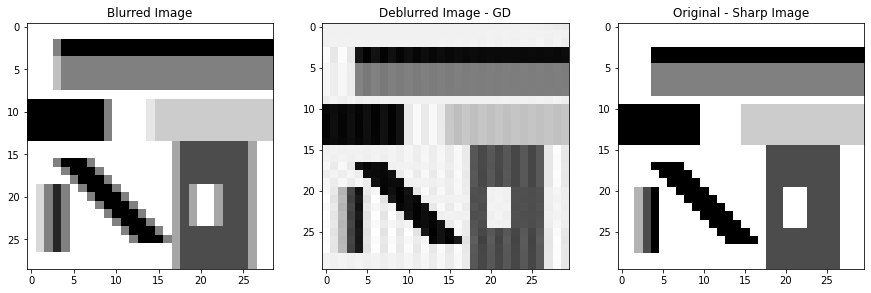

----------------
For lambda 0.00100	 
k_type 0
Loss Data Term = 0.9272155709528759
Sum of Squared Distance: deblurred vs. original = 0.6022985759289944


In [13]:
gd_epsilon = 0.1
gd_stop_criteria = 10**(-4)

print(f"Running gradient descent with convergence criteria = {gd_stop_criteria}, step size = {gd_epsilon}")
print(f"Regularization term: {reg_term} with lambda = {reg_lambda}")
# run gradient descent algorithm
start = time.time()
img_deblurred_gd = GD(img_blurred, reg_lambda, reg_term=reg_term, epsilon=gd_epsilon, stop_criteria=gd_stop_criteria)
stop = time.time()
print(f"Elapsed: {stop - start}s")

# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print("----------------")
print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")
print(f"Loss Data Term = {loss_term(img_deblurred_gd, img_blurred)}")
print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_gd, img_org)}")  

### Impact of regularization parameter lambda on Gradient Descent

Below we visually evaluate the efect of the regularization parameter on deblurring using gradient descent.

In [14]:
gd_stop_criteria = 10**(-3)

gd_no_regularization = GD(img_blurred, 0, no_regularization, stop_criteria = gd_stop_criteria)

gd_gaussian_001 = GD(img_blurred, 0.001, gaussian_regularization, stop_criteria=gd_stop_criteria)
gd_gaussian_01 = GD(img_blurred, 0.01, gaussian_regularization, stop_criteria=gd_stop_criteria)
gd_gaussian_1 = GD(img_blurred, 0.1, gaussian_regularization, stop_criteria=gd_stop_criteria)

gd_anisotropic_001 = GD(img_blurred, 0.001, anisotropic_regularization, stop_criteria=gd_stop_criteria)
gd_anisotropic_01 = GD(img_blurred, 0.01, anisotropic_regularization, stop_criteria=gd_stop_criteria)
gd_anisotropic_1 = GD(img_blurred, 0.1, anisotropic_regularization, stop_criteria=gd_stop_criteria)  

Gradient descent: Stopping after 3632 iterations. Norm of gradient = 0.000999655889834887
Gradient descent: Stopping after 3636 iterations. Norm of gradient = 0.0009995831359592322
Gradient descent: Stopping after 1258 iterations. Norm of gradient = 0.0009979799981847117
Gradient descent: Stopping after 263 iterations. Norm of gradient = 0.0009960396293816844
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Current iteration: 60000
Current iteration: 70000
Current iteration: 80000
Current iteration: 90000
Current iteration: 100000
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Current iteration: 60000
Current iteration: 70000
Current iteration: 80000
Current iteration: 90000
Current iteration: 100000
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Current ite

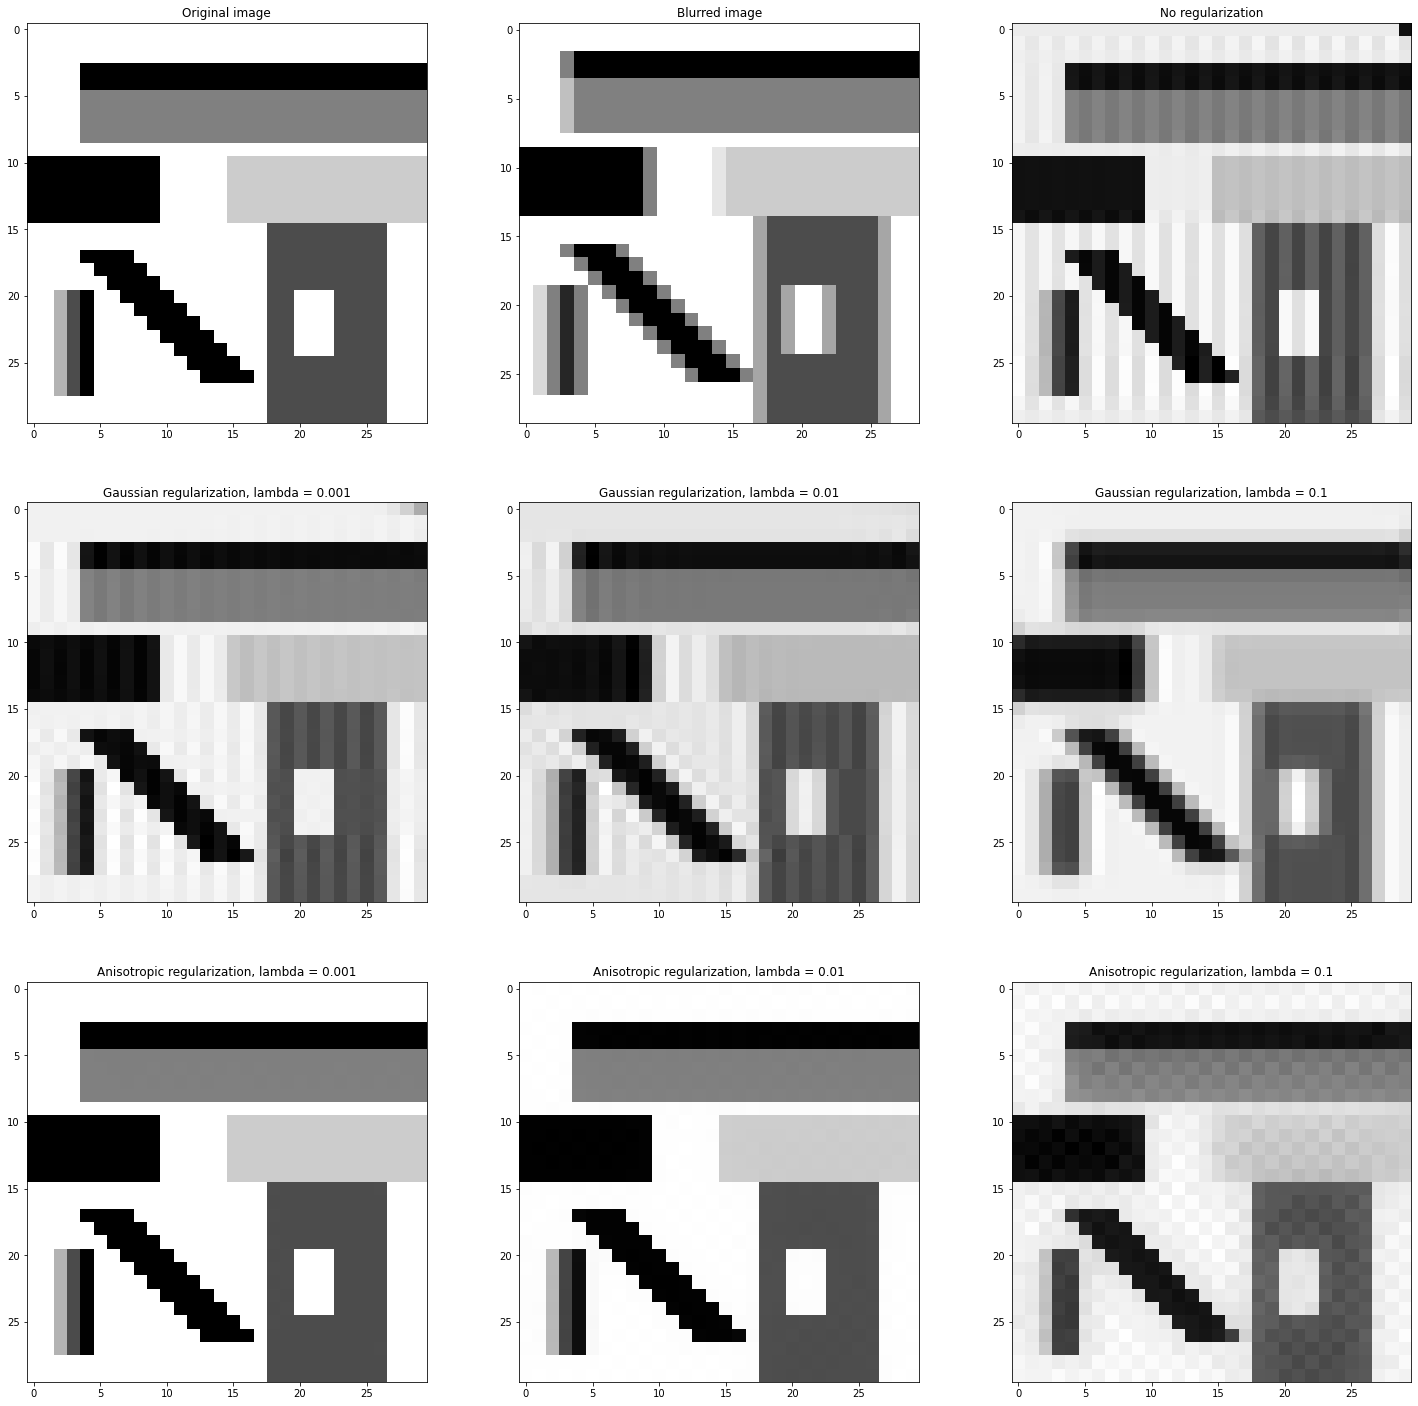

In [15]:
plot_rows = 3
plot_cols = 3
plt.figure(figsize=(25, 25))

ax1 = plt.subplot(plot_rows, plot_cols, 1)
plt.imshow(img_org, cmap='gray')
ax1.set_title("Original image")

ax2 = plt.subplot(plot_rows, plot_cols, 2)
plt.imshow(img_blurred, cmap='gray')
ax2.set_title("Blurred image")

ax3 = plt.subplot(plot_rows, plot_cols, 3)
plt.imshow(gd_no_regularization, cmap='gray')
ax3.set_title("No regularization")


ax4 = plt.subplot(plot_rows, plot_cols, 4)
plt.imshow(gd_gaussian_001, cmap='gray')
ax4.set_title("Gaussian regularization, lambda = 0.001")

ax5 = plt.subplot(plot_rows, plot_cols, 5)
plt.imshow(gd_gaussian_01, cmap='gray')
ax5.set_title("Gaussian regularization, lambda = 0.01")

ax6 = plt.subplot(plot_rows, plot_cols, 6)
plt.imshow(gd_gaussian_1, cmap='gray')
ax6.set_title("Gaussian regularization, lambda = 0.1")


ax7 = plt.subplot(plot_rows, plot_cols, 7)
plt.imshow(gd_anisotropic_001, cmap='gray')
ax7.set_title("Anisotropic regularization, lambda = 0.001")

ax8 = plt.subplot(plot_rows, plot_cols, 8)
plt.imshow(gd_anisotropic_01, cmap='gray')
ax8.set_title("Anisotropic regularization, lambda = 0.01")

ax9 = plt.subplot(plot_rows, plot_cols, 9)
plt.imshow(gd_anisotropic_1, cmap='gray')
ax9.set_title("Anisotropic regularization, lambda = 0.1")

plt.show()

With no regularization, the reconstruction is mediocre. While the shapes seem decently deblurred, the lighter colours use a lot of saturation, and artefacts are introduced. Further the model is unable to compensate for the one additional row of the output image, as it assumes that no noise was present at all.

Gaussian regularization performs as one would expect, with - the higher regularization is weighted using the lambda parameter - gaussian noise being applied. If this is overdone however, sucha s with lambda = 0.1, then the result is simply an even more blurry image. In fact, none of the reconstructions using Gaussian regularization seem better than not using any regularization.

Anisotropic regularization lastly performs exceedingly well, as long as the lambda parameter is set low enough.

The best reconstruction seems to be the result of anisotropic regularization with lambda = 0.01.

## SOR

Running SOR with convergence criteria = 0.001, w = 1.5
Regularization term: <function gaussian_regularization at 0x000001D955CBEAF0> with lambda = 0.001
Current iteration: 10
Current iteration: 20
Current iteration: 30
Current iteration: 40
Current iteration: 50
Current iteration: 60
Current iteration: 70
Current iteration: 80
Current iteration: 90
Current iteration: 100
Elapsed: 18.29506754875183s


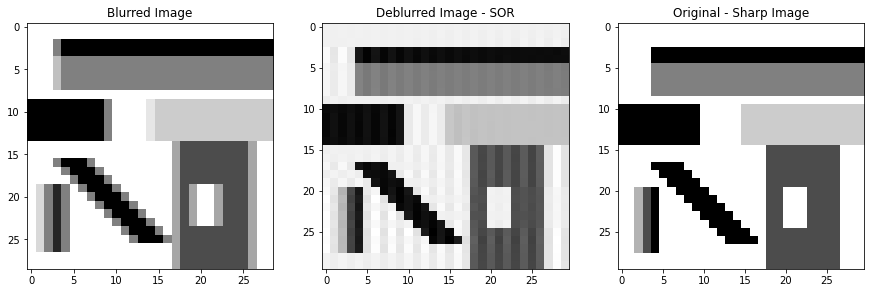

----------------
For lambda 0.00100
Loss Data Term = 0.9491474112706388
Sum of Squared Distance: deblurred vs. original = 0.8037164234753552


In [19]:
w = 1.5 #play with this
sor_stop_criteria = 10**(-3)

print(f"Running SOR with convergence criteria = {sor_stop_criteria}, w = {w}")
print(f"Regularization term: {reg_term} with lambda = {reg_lambda}")

# run LSOR algorithm
start = time.time()
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w, reg_term=reg_term, stop_criteria=sor_stop_criteria)
stop = time.time()
print(f"Elapsed: {stop - start}s")

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - SOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print("----------------")
print(f"For lambda {reg_lambda:.5f}")
print(f"Loss Data Term = {loss_term(img_deblurred_sor, img_blurred)}")
print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_sor, img_org)}")

## GAUSS - SEIDEL

Running linearized gauss-seidel with convergence criteria = 0.001
Regularization term: <function gaussian_regularization at 0x000001D955CBEAF0> with lambda = 0.001
Current iteration: 10
Current iteration: 20
Current iteration: 30
Current iteration: 40
Current iteration: 50
Current iteration: 60
Current iteration: 70
Current iteration: 80
Current iteration: 90
Current iteration: 100
Elapsed: 18.618203163146973s


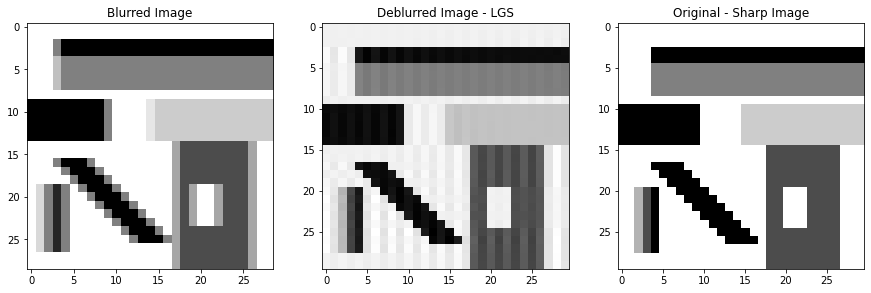

----------------
For lambda 0.00100
Loss Data Term = 0.9491474112706393
Sum of Squared Distance: deblurred vs. original = 0.8037164234753624


In [20]:
lgs_stop_criteria = 10**(-3)

print(f"Running linearized gauss-seidel with convergence criteria = {lgs_stop_criteria}")
print(f"Regularization term: {reg_term} with lambda = {reg_lambda}")

# run LGS algorithm
start = time.time()
img_deblurred_gs = LGS(img_blurred, reg_lambda, reg_term=reg_term, stop_criteria=lgs_stop_criteria)

stop = time.time()

print(f"Elapsed: {stop - start}s")

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print("----------------")
print(f"For lambda {reg_lambda:.5f}")
print(f"Loss Data Term = {loss_term(img_deblurred_gs, img_blurred)}")
print(f"Sum of Squared Distance: deblurred vs. original = {ssd(img_deblurred_gs, img_org)}")  

## Impact of regularization parameter

In the analysis below, we will evaluate the impact of different values for the regularization parameter lambda on the reconstruction, using the gradient descent method with the anisotropic regularization term.

The lambda parameter is the weight of the regularization parameter. As such it governs the assumption of how much noise there was assumed to be present in the system, when reconstructing the image.

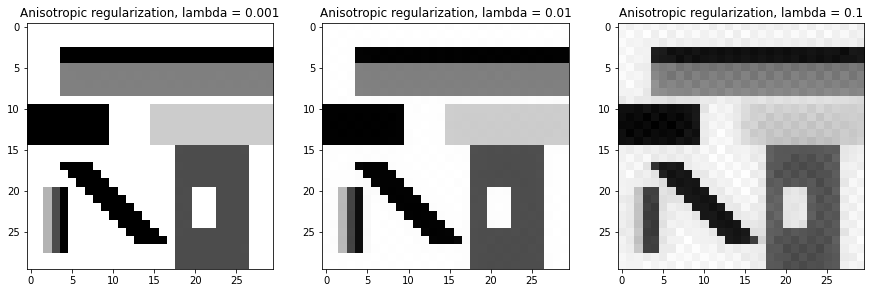

In [21]:
plot_rows = 1
plot_cols = 3

plt.figure(figsize=(15, 5))

ax1 = plt.subplot(plot_rows, plot_cols, 1)
plt.imshow(gd_anisotropic_001, cmap='gray')
ax1.set_title("Anisotropic regularization, lambda = 0.001")

ax2 = plt.subplot(plot_rows, plot_cols, 2)
plt.imshow(gd_anisotropic_01, cmap='gray')
ax2.set_title("Anisotropic regularization, lambda = 0.01")

ax3 = plt.subplot(plot_rows, plot_cols, 3)
plt.imshow(gd_anisotropic_1, cmap='gray')
ax3.set_title("Anisotropic regularization, lambda = 0.1")

plt.show()

Clearly a value of lambda around 0.01 provides the best results. With higher value, the resulting image becomes noisy once more.

We now want to analyse the effect different values of lambda have on the sum-of-squared-differences of the reconstructed image with the original. The graph below shows how the SSD changes as lambda is changed.

In [22]:
gd_stop_criteria = 10**(-3)
lambda_values = [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 1]
ssd_values_anisotropic = []
ssd_values_gaussian = []

for l in lambda_values:
    img_anisotropic = GD(img_blurred, l, anisotropic_regularization, stop_criteria = gd_stop_criteria, max_iter = 50000)
    ssd_values_anisotropic.append(ssd(img_anisotropic, img_org))
    
    img_gaussian = GD(img_blurred, l, gaussian_regularization, stop_criteria = gd_stop_criteria, max_iter = 50000)
    ssd_values_gaussian.append(ssd(img_gaussian, img_org))


Gradient descent: Stopping after 3632 iterations. Norm of gradient = 0.000999655889834887
Gradient descent: Stopping after 3632 iterations. Norm of gradient = 0.000999655889834887
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Gradient descent: Stopping after 3721 iterations. Norm of gradient = 0.00099967366066704
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Gradient descent: Stopping after 4183 iterations. Norm of gradient = 0.0009998699576678892
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Gradient descent: Stopping after 4457 iterations. Norm of gradient = 0.0009999792325710187
Current iteration: 10000
Current iteration: 20000
Current iteration: 30000
Current iteration: 40000
Current iteration: 50000
Gradient descent: Stopping after 4450 iterations.

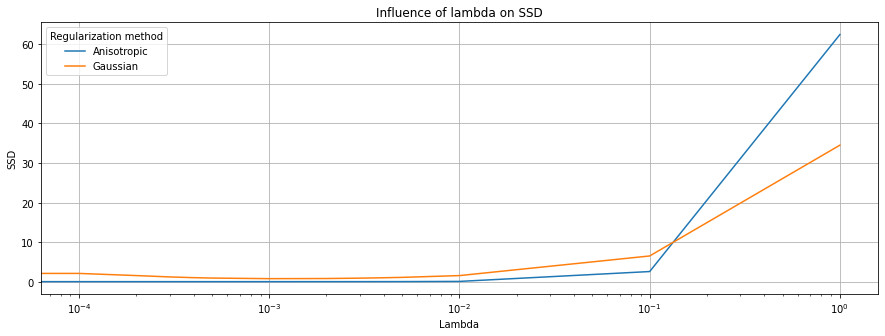

In [23]:
plt.figure(figsize=(15, 5))

plt.title("Influence of lambda on SSD")
plt.xlabel("Lambda")
plt.ylabel("SSD")

plt.plot(lambda_values, ssd_values_anisotropic, label = "Anisotropic")
plt.plot(lambda_values, ssd_values_gaussian, label = "Gaussian")
plt.legend(title='Regularization method')
plt.xscale("log")
plt.grid()
plt.show() 

This graph nicely shows that ideal values for the regularization parameter are - both for Gaussian as well as anisotropic regularization - around $10^-3$  to $10^-2$. below this range, the impact of the regularization parameter becomes neglibible. Above, the reconstructed image becomes too noisy.